In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install gdown
!pip install opendatasets
!pip install transformers torch torchvision pillow
#BEIT 
#!git clone https://github.com/microsoft/unilm.git

In [3]:
#download requirements
#%cd /kaggle/working/unilm/beit3
#!pip install -r requirements.txt

In [4]:
#https://drive.google.com/file/d/1l9wG9fT674kiL_P2-ll4C7fBZI_7ddrn/view?usp=sharing
#https://drive.google.com/file/d/1eSk4RteggZqQhuWEyo5BazCnCBhRnvE5/view
#!gdown 1l9wG9fT674kiL_P2-ll4C7fBZI_7ddrn
#!gdown 1eSk4RteggZqQhuWEyo5BazCnCBhRnvE5

In [5]:
#!unzip -qq image.zip
#!unzip -qq open.zip

In [6]:
import opendatasets as od
import random
import re
import torch
import torch.nn as nn
import pandas as pd
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
# from transformers import BertTokenizer, BertForMaskedLM
# from transformers import DistilBertModel, DistilBertTokenizer
from transformers import GPT2Tokenizer, GPT2Model
from transformers import XLMRobertaTokenizer, get_cosine_schedule_with_warmup

from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import os
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
od.download("https://www.kaggle.com/datasets/ttony0321/imagesam")
#a58c2b0c44b811621fa5d634999d13c6#

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ttony0321


Your Kaggle Key:

  ································


100%|██████████| 7.20G/7.20G [05:55<00:00, 21.7MB/s]  


In [8]:
path = '/kaggle/working/imagesam'
train = pd.read_csv(f'{path}/train.csv')
test = pd.read_csv(f'{path}/test.csv')

In [9]:
train['img_path'] = train['img_path'].str.replace('./train/', '/kaggle/working/imagesam/train/')
test['img_path'] = test['img_path'].str.replace('./test/', '/kaggle/working/imagesam/test/')

In [10]:
#clean text
def clean_text(sample):
    sample = sample.lower()
    sample = re.sub("[^a-z]+"," ",sample)
    sample = sample.split()
    sample = [s for s in sample if len(s)>1]
    sample = " ".join(sample)
    return sample

In [11]:
train['comments']= train['comments'].apply(clean_text)

In [12]:
train.head()

,img_name,img_path,mos,comments
0,41wy7upxzl,/kaggle/working/imagesam/train/41wy7upxzl.jpg,5.569231,the pink and blue really compliment each other...
1,ygujjq6xxt,/kaggle/working/imagesam/train/ygujjq6xxt.jpg,6.103175,love rhubarb great colors
2,wk321130q0,/kaggle/working/imagesam/train/wk321130q0.jpg,5.541985,enjoy the textures and grungy feel to this als...
3,w50dp2zjpg,/kaggle/working/imagesam/train/w50dp2zjpg.jpg,6.234848,like all the different colours in this pic the...
4,l7rqfxeuh0,/kaggle/working/imagesam/train/l7rqfxeuh0.jpg,5.190476,love these critters just wish he was little sh...


In [46]:
test.head()

,img_name,mos,comments
0,j00zs3u6dr,"(5.797519683837891, '')",Nice Image.
1,ytv70so3zb,"(6.121859550476074, '')",Nice Image.
2,ia9890oozp,"(5.224483489990234, '')",Nice Image.
3,xsj81ypx4a,"(5.7579426765441895, '')",Nice Image.
4,f23994ghlh,"(4.8010640144348145, '')",Nice Image.


In [14]:
train[train['mos'] == 0]

,img_name,img_path,mos,comments


In [15]:
CFG = {
    'IMG_SIZE':320,
    'EPOCHS':5,
    'LR':1e-5, 
    'BATCH_SIZE':24,
    'SEED':1234
}

In [16]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

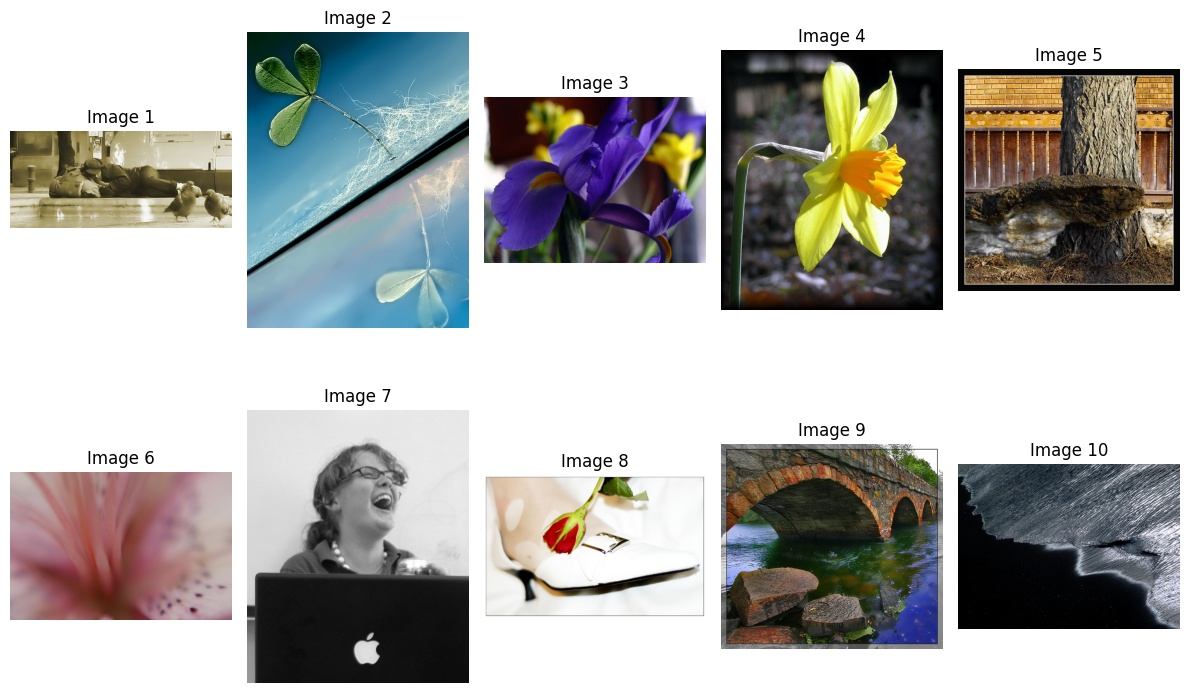

In [17]:
#Checking Images
random_images = random.sample(sorted(train["img_path"]), 10)
plt.figure(figsize=(12, 8))
for i, img_path in enumerate(random_images, 1):
    plt.subplot(2, 5, i)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Image {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [18]:
#mos평가기준:선명도, 노이즈, 색감, 선호도 등
#캡셔닝: 영어 Text 
#별개모델
#*(2018 TIP) Sebastian Bosse, "Deep Neural Networks for No-Reference and Full-Reference Image Quality Assessment"
#*(2018 TIP) Hossein Talebi, "NIMA: Neural Image Assessment"
#mos: 완전 별개의사진들, 흑백, 색
#captioning
#BERT, VisualBERT
#GPT?
#DenscCap?

In [19]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['img_path']
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        # mos column 존재 여부에 따라 값을 설정
        mos = float(self.dataframe.iloc[idx]['mos']) if 'mos' in self.dataframe.columns else 0.0
        comment = self.dataframe.iloc[idx]['comments'] if 'comments' in self.dataframe.columns else ""
        
        return img, mos, comment

In [20]:
class CustommosDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['img_path']
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        # mos column 존재 여부에 따라 값을 설정
        mos = float(self.dataframe.iloc[idx]['mos']) if 'mos' in self.dataframe.columns else 0.0
        #comment = self.dataframe.iloc[idx]['comments'] if 'comments' in self.dataframe.columns else ""
        
        return img, mos

In [21]:
# tokenizer = XLMRobertaTokenizer(os.path.join(base_path, 'models', 'beit3.spm'))
# train_dataset = VQADataset(train_df, tokenizer, train_img_path, img_size=CFG['IMG_SIZE'], is_train=True)
# train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=8)

In [22]:
train

,img_name,img_path,mos,comments
0,41wy7upxzl,/kaggle/working/imagesam/train/41wy7upxzl.jpg,5.569231,the pink and blue really compliment each other...
1,ygujjq6xxt,/kaggle/working/imagesam/train/ygujjq6xxt.jpg,6.103175,love rhubarb great colors
2,wk321130q0,/kaggle/working/imagesam/train/wk321130q0.jpg,5.541985,enjoy the textures and grungy feel to this als...
3,w50dp2zjpg,/kaggle/working/imagesam/train/w50dp2zjpg.jpg,6.234848,like all the different colours in this pic the...
4,l7rqfxeuh0,/kaggle/working/imagesam/train/l7rqfxeuh0.jpg,5.190476,love these critters just wish he was little sh...
...,...,...,...,...
74563,zbevd0lyox,/kaggle/working/imagesam/train/zbevd0lyox.jpg,5.926108,perfect balance here in this soft serene image
74564,w26yu6ee60,/kaggle/working/imagesam/train/w26yu6ee60.jpg,5.966346,very nice indeed the sharpness and contrast ar...
74565,a1pts9zzdx,/kaggle/working/imagesam/train/a1pts9zzdx.jpg,5.718447,nice tones and color for balance
74566,pzbubeo03l,/kaggle/working/imagesam/train/pzbubeo03l.jpg,6.007843,like the bold colors nice sharp image


In [23]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

        # Image feature extraction using ResNet50
        #self.cnn_backbone = models.resnet50(pretrained=True)
        #self.cnn_backbone = models.resnet101(pretrained=True)#152
        #if using Efficientnet
        #EfficientNet_B2_Weights.IMAGENET1K_V1   _288
        #EfficientNet_B3_Weights.IMAGENET1K_V1   _ 320
        weights = models.EfficientNet_B2_Weights.IMAGENET1K_V1
        self.cnn_backbone = models.efficientnet_b2(weights=weights)
        #self.cnn_backbone = models.efficientnet_b1(pretrained=True)#b0~b7

        # Remove the last fully connected layer to get features
        modules = list(self.cnn_backbone.children())[:-1]
        self.cnn = nn.Sequential(*modules)
        #RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x1408 and 1280x1)

        # Image quality assessment head
        #self.regression_head = nn.Linear(2048, 1)  # ResNet50 last layer has 2048 features
        self.regression_head = nn.Linear(1408, 1)
        # Captioning head
#         self.embedding = nn.Embedding(vocab_size, embed_dim)
#         self.lstm = nn.LSTM(embed_dim + 1536, hidden_dim)  # Image features and caption embeddings as input
#         self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, images, captions=None):
        # CNN
        features = self.cnn(images)
        features_flat = features.view(features.size(0), -1)

        # Image quality regression
        mos = self.regression_head(features_flat)
        return mos
        # LSTM captioning
#         if captions is not None:
#             embeddings = self.embedding(captions)
#             # Concatenate image features and embeddings for each word in the captions
#             combined = torch.cat([features_flat.unsqueeze(1).repeat(1, embeddings.size(1), 1), embeddings], dim=2)
#             lstm_out, _ = self.lstm(combined)
#             outputs = self.fc(lstm_out)
#             return mos, outputs
#         else:
#             return mos, None

In [26]:
train_df = train.drop('comments', axis=1)
train_df

,img_name,img_path,mos
0,41wy7upxzl,/kaggle/working/imagesam/train/41wy7upxzl.jpg,5.569231
1,ygujjq6xxt,/kaggle/working/imagesam/train/ygujjq6xxt.jpg,6.103175
2,wk321130q0,/kaggle/working/imagesam/train/wk321130q0.jpg,5.541985
3,w50dp2zjpg,/kaggle/working/imagesam/train/w50dp2zjpg.jpg,6.234848
4,l7rqfxeuh0,/kaggle/working/imagesam/train/l7rqfxeuh0.jpg,5.190476
...,...,...,...
74563,zbevd0lyox,/kaggle/working/imagesam/train/zbevd0lyox.jpg,5.926108
74564,w26yu6ee60,/kaggle/working/imagesam/train/w26yu6ee60.jpg,5.966346
74565,a1pts9zzdx,/kaggle/working/imagesam/train/a1pts9zzdx.jpg,5.718447
74566,pzbubeo03l,/kaggle/working/imagesam/train/pzbubeo03l.jpg,6.007843


In [28]:
# 데이터 로드
#train_data = pd.read_csv('train.csv')
train_data = train_df

# 데이터셋 및 DataLoader 생성
transform = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
])
#Base
train_dataset = CustommosDataset(train_data, transform)
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
# train_dataset = MetalDataset(train_data, transform)
# train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

# 모델, 손실함수, 옵티마이저
model = BaseModel().cuda()
#model = nn.DataParallel(model, device_ids=[0, 1]) #multi GPUS
criterion1 = nn.MSELoss()
#criterion2 = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['LR'])

# 학습
model.train()
for epoch in range(CFG['EPOCHS']):
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    for imgs, mos in loop:
        imgs, mos = imgs.float().cuda(), mos.float().cuda()
        
        # Batch Preprocessing
#         comments_tensor = torch.zeros((len(comments), len(max(comments, key=len)))).long().cuda()
#         for i, comment in enumerate(comments):
#             tokenized = ['<SOS>'] + comment.split() + ['<EOS>']
#             comments_tensor[i, :len(tokenized)] = torch.tensor([word2idx[word] for word in tokenized])

        # Forward & Loss
        predicted_mos = model(imgs)
        loss1 = criterion1(predicted_mos.squeeze(1), mos)
        #loss2 = criterion2(predicted_comments.view(-1, len(vocab)), comments_tensor.view(-1))
        loss = loss1

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1} finished with average loss: {total_loss / len(train_loader):.4f}")

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:03<00:00, 12.1MB/s]
Epoch 1:   0%|          | 2/3107 [00:06<2:20:42,  2.72s/it, loss=34.5]/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 1:  52%|█████▏    | 1605/3107 [11:57<11:02,  2.27it/s, loss=0.472]/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch 1: 100%|██████████| 3107/3107 [23:04<00:00,  2.24it/s, loss=0.305]


Epoch 1 finished with average loss: 2.9844


Epoch 2: 100%|██████████| 3107/3107 [23:32<00:00,  2.20it/s, loss=0.323]


Epoch 2 finished with average loss: 0.4655


Epoch 3: 100%|██████████| 3107/3107 [22:49<00:00,  2.27it/s, loss=0.577]


Epoch 3 finished with average loss: 0.4044


Epoch 4: 100%|██████████| 3107/3107 [22:47<00:00,  2.27it/s, loss=0.181]


Epoch 4 finished with average loss: 0.3649


Epoch 5: 100%|██████████| 3107/3107 [22:47<00:00,  2.27it/s, loss=0.354] 

Epoch 5 finished with average loss: 0.3317


In [29]:
{total_loss / len(train_loader)}
"{:.4f}".format(total_loss / len(train_loader))

'0.3317'

In [30]:
#model save
loss = "{:.4f}".format(total_loss / len(train_loader))
torch.save(model, f"/kaggle/working/imagesam/model_{loss}.pt")

In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))


In [ ]:
download_file('/kaggle/working/imagesam/model_0.8139.pt', 'out')

In [ ]:
# test = pd.read_csv(f'{path}/test.csv')
# test['img_path'] = test['img_path'].str.replace('./test/', '/kaggle/working/imagesam/test/')

In [53]:
import os
#os.listdir('/kaggle/input/test2-csv/test.csv')
test = pd.read_csv('/kaggle/input/test2-csv/test.csv')
test['img_path'] = test['img_path'].str.replace('./test/', '/kaggle/working/imagesam/test/')
test

,img_name,img_path
0,j00zs3u6dr,/kaggle/working/imagesam/test/j00zs3u6dr.jpg
1,ytv70so3zb,/kaggle/working/imagesam/test/ytv70so3zb.jpg
2,ia9890oozp,/kaggle/working/imagesam/test/ia9890oozp.jpg
3,xsj81ypx4a,/kaggle/working/imagesam/test/xsj81ypx4a.jpg
4,f23994ghlh,/kaggle/working/imagesam/test/f23994ghlh.jpg
...,...,...
13007,ya8k1hklrg,/kaggle/working/imagesam/test/ya8k1hklrg.jpg
13008,j59djzkvpj,/kaggle/working/imagesam/test/j59djzkvpj.jpg
13009,o6w8lkfdy0,/kaggle/working/imagesam/test/o6w8lkfdy0.jpg
13010,hq68sz9xf5,/kaggle/working/imagesam/test/hq68sz9xf5.jpg


In [57]:
#test = pd.read_csv('/kaggle/input/test2-csv')
test_data = test
test_dataset = CustommosDataset(test_data, transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predicted_mos_list = []
predicted_comments_list = []

def greedy_decode(model, image, max_length=50):
    image = image.unsqueeze(0).cuda()
    mos = model(image)
    output_sentence = []
    
    # 시작 토큰 설정
    #current_token = torch.tensor([word2idx['<SOS>']]).cuda()
    #hidden = None
    #features = model.cnn(image).view(image.size(0), -1)
    #features = model.module.cnn(image).view(image.size(0), -1)
#     for _ in range(max_length):
        
#         out, hidden = model.lstm(combined, hidden)
#         #out, hidden = model.module.lstm(combined, hidden)
        
#         output = model.fc(out.squeeze(0))
    return mos.item(), ' '.join(output_sentence)

# 추론 과정
with torch.no_grad():
    for imgs, _ in tqdm(test_loader):
        for img in imgs:
            img = img.float().cuda()
            mos, _ = greedy_decode(model, img)
            predicted_mos_list.append(mos)
            #predicted_comments_list.append(caption)
#print(predicted_comments_list)
# 결과 저장
result_df = pd.DataFrame({
    'img_name': test_data['img_name'],
    'mos': predicted_mos_list,
    'comments': ''  # 캡션 부분은 위에서 생성한 것을 사용
})

# 예측 결과에 NaN이 있다면, 제출 시 오류가 발생하므로 후처리 진행 (sample_submission.csv과 동일하게)
result_df['comments'] = result_df['comments'].fillna('Nice Image.')
result_df.to_csv('submit.csv', index=False)

print("Inference completed and results saved to submit.csv.")

100%|██████████| 407/407 [04:14<00:00,  1.60it/s]

Inference completed and results saved to submit.csv.


In [58]:
test = pd.read_csv('submit.csv')
test
test['comments'] = test['comments'].fillna('Nice Image.')
test.to_csv('submit_f2.csv', index=False)

In [59]:
test

,img_name,mos,comments
0,j00zs3u6dr,5.797520,Nice Image.
1,ytv70so3zb,6.121860,Nice Image.
2,ia9890oozp,5.224483,Nice Image.
3,xsj81ypx4a,5.757943,Nice Image.
4,f23994ghlh,4.801064,Nice Image.
...,...,...,...
13007,ya8k1hklrg,4.535677,Nice Image.
13008,j59djzkvpj,4.467164,Nice Image.
13009,o6w8lkfdy0,4.263592,Nice Image.
13010,hq68sz9xf5,4.509837,Nice Image.
